# Single Series Analysis

In [1]:
import os

import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
import h5py
from anytree import Node, RenderTree
import nexusformat.nexus as nx
import pickle
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio
import matplotlib.cm as cm
import matplotlib.dates as mdates
import statsmodels.graphics.tsaplots as tsaplots



from fault_management_uds.data.data_utilities import print_tree
from fault_management_uds.data.load_save_data import load_dataframe, save_dataframe, overwrite_dataset, save_filtered_data
from fault_management_uds.data.load_save_data import save_metadata, load_metadata, import_metadata
from fault_management_uds.plots import set_meaningful_xaxis_timestamps, get_segment_start_end_color


from fault_management_uds.config import PROJ_ROOT
from fault_management_uds.config import DATA_DIR, RAW_DATA_DIR, INTERIM_DATA_DIR, PROCESSED_DATA_DIR, EXTERNAL_DATA_DIR
from fault_management_uds.config import MODELS_DIR, REPORTS_DIR, FIGURES_DIR
from fault_management_uds.config import rain_gauges, natural_structure_order, natural_sensor_order, series_order, error_indicators

2024-10-07 07:49:51.798 | INFO     | fault_management_uds.config:<module>:11 - PROJ_ROOT path is: /Users/arond.jacobsen/Documents/GitHub/fault_management_uds


In [3]:
np.random.seed(11)

## Load data

In [4]:
data_file_path = PROCESSED_DATA_DIR / 'Bellinge.h5'

In [5]:
single_series_path = '/processed/single_series'
f = print_tree(data_file_path, group=single_series_path)

single_series
├── 5425
│   ├── columns
│   ├── data
│   └── timestamps
├── 5427
│   ├── columns
│   ├── data
│   └── timestamps
├── G71F04R_Level1
│   ├── columns
│   ├── data
│   └── timestamps
├── G71F04R_Level2
│   ├── columns
│   ├── data
│   └── timestamps
├── G71F05R_LevelBasin
│   ├── columns
│   ├── data
│   └── timestamps
├── G71F05R_LevelInlet
│   ├── columns
│   ├── data
│   └── timestamps
├── G71F05R_position
│   ├── columns
│   ├── data
│   └── timestamps
├── G71F06R_LevelInlet
│   ├── columns
│   ├── data
│   └── timestamps
├── G71F68Y_LevelPS
│   ├── columns
│   ├── data
│   └── timestamps
├── G71F68Yp1
│   ├── columns
│   ├── data
│   └── timestamps
├── G72F040
│   ├── columns
│   ├── data
│   └── timestamps
├── G73F010
│   ├── columns
│   ├── data
│   └── timestamps
├── G80F11B_Level1
│   ├── columns
│   ├── data
│   └── timestamps
├── G80F11B_Level2
│   ├── columns
│   ├── data
│   └── timestamps
├── G80F13P_LevelPS
│   ├── columns
│   ├── data
│   └── timestamps
├── 

In [6]:
series_name = 'G71F04R_Level2'
series_path = single_series_path + '/' + series_name

starttime = "01-01-2019 00:00:00"
endtime = "01-01-2021 00:00:00"

return_type = "df"

In [7]:
series, timestamps, columns, start_idx, end_idx, column_indices = load_dataframe(
    data_file_path, series_path, 
    return_type=return_type, #starttime=starttime, endtime=endtime
    )

        Data loaded from group '/processed/single_series/G71F04R_Level2'


In [8]:
# check that 
def evaluate_consistency(data, time_column):
    # Check for missing timestamps
    start_date = data[time_column].min()
    end_date = data[time_column].max()
    full_range = pd.date_range(start=start_date, end=end_date, freq='1min')
    missing_data = full_range.difference(data[time_column])
    print(f"Number of missing timestamps: {len(missing_data)} out of {len(full_range)}")    
    return missing_data

missing_data = evaluate_consistency(series.copy().reset_index(), 'time')

Number of missing timestamps: 0 out of 5811721


In [10]:
print(series.shape)

(5811721, 12)


In [11]:
series.head(1)

,raw,cleaned,interpolated,no_data,is_error,man_remove,stamp,outbound,frozen,outlier,stamped,frozen_high
time,,,,,,,,,,,,
2010-08-01,0.116,0.116,0.116,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Timeline

In [12]:
error_indicators

['stamped', 'man_remove', 'outbound', 'outlier', 'frozen', 'frozen_high']

In [13]:
def create_series_I(series, error_indicators):
    # let's create the indicator dataframe
    timestamps_df = pd.DataFrame(series.index, columns=['time'])
    raw = series.raw
    I = np.zeros_like(raw) # 0 where there is zero value data
    I[(raw > 0).values] = 1 # 1 where there is data
    I[(series.no_data > 0).values] = 2 # 2 where there is no data
    next_error_indicator = 3
    for error_indicator in error_indicators:
        I[(series[error_indicator] > 0).values] = next_error_indicator
        next_error_indicator += 1
    return timestamps_df, I

timestamps_df, I = create_series_I(series, error_indicators)

In [14]:
I.shape

(5811721,)

In [15]:
indicator_metadata = {
    # Plotting order
    'No Data': {
        'color': 'linen',
        'value': 2
    },
    'Data': {
        'color': 'forestgreen',
        'value': 1
    },
    'Zero Valued': {
        #'color': 'honeydew',
        'color': 'lightgreen',
        'value': 0
    },
    'Stamped': {
        'color': 'slategray',
        'value': 3
    },
    'Manual Removal': {
        'color': 'mediumslateblue',
        'value': 4
    },
    'Outbound': {
        'color': 'lightcoral',
        'value': 5
    },
    'Outlier': {
        'color': 'firebrick',
        'value': 6
    },
    'Frozen': {
        'color': 'lightskyblue',
        'value': 7
    },
    'Frozen High': {
        'color': 'steelblue',
        'value': 8
    },
}

# create the index to color mapping
indicator_2_color = {v['value']: v['color'] for k, v in indicator_metadata.items()}
indicator_2_name = {v['value']: k for k, v in indicator_metadata.items()}
name_2_color = {k: v['color'] for k, v in indicator_metadata.items()}
color_2_name = {v['color']: k for k, v in indicator_metadata.items()}

In [17]:
def visualize_single_timeline(I, timestamps_df, variable, indicator_2_color, name_2_color, figsize=(16, 4)):
    """
    Visualize the timeline of the data with different indicators
    """

    # if I is 1D, convert it to 2D
    if len(I.shape) == 1:
        I = I.reshape(1, -1)

    # Transpose the 2D array I to have the variables as rows
    #I = I.copy().T

    # Set up the figure and axes
    fig, ax = plt.subplots(figsize=figsize, dpi=400)

    bar_width = 0.4


    # Iterate over each row in the 2D array I to plot segments
    for i, row in enumerate(I):
        segment_starts, segment_ends, segment_color = get_segment_start_end_color(row, indicator_2_color)
        segments = np.column_stack((segment_starts, segment_ends - segment_starts))
        # plot the segments
        ax.broken_barh(segments, (i - bar_width/2, bar_width), facecolors=segment_color)


    # Set the legend
    legend_elements = [Patch(facecolor=color, label=name) for name, color in name_2_color.items()]
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))

    # expand the y-axis to make the plot look better
    ax.set_ylabel(variable, rotation=90, ha="center")
    ax.set_yticks([])  # Remove y-axis ticks and labels
    ax.set_ylim(-bar_width/2, bar_width/2)
    ax.invert_yaxis()


    # Set the x-axis
    ax = set_meaningful_xaxis_timestamps(ax, timestamps_df)

    # # add vertical lines for the years
    # for year in year_start_idx:
    #     ax.axvline(x=year, color='lightgray', linestyle='--', linewidth=0.5)
    # remove outer frame
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
    # Show the plot
    plt.tight_layout()
    plt.show()

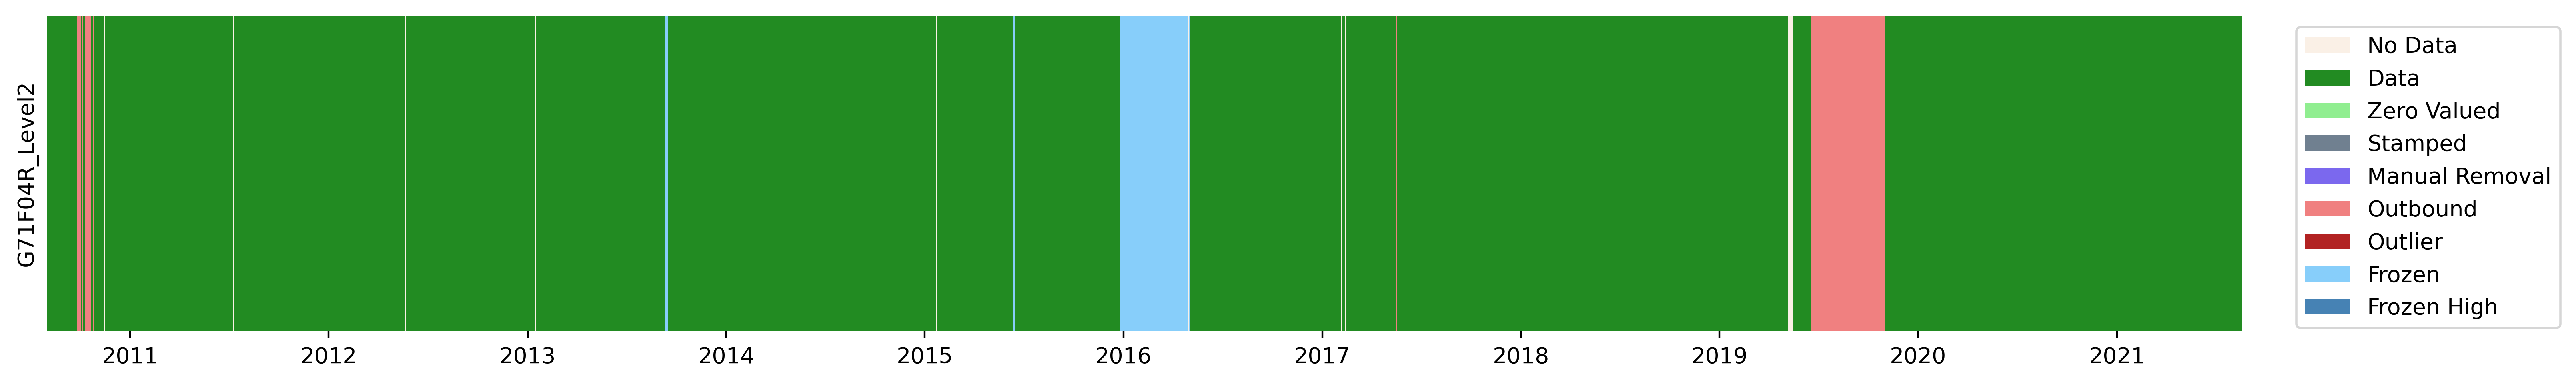

In [88]:
# visualize the timeline
visualize_single_timeline(I, timestamps_df, series_name, indicator_2_color, name_2_color, figsize=(16, 2.5))

# Biases

In [36]:
# zero value
I_df = pd.DataFrame(I, columns=['Indicator'])
# aggregate the data, group by the unique values of I and count the number of occurences
I_agg_df = I_df['Indicator'].value_counts().to_frame().reset_index().rename(columns={'count': 'Count'})
I_agg_df['Name'] = I_agg_df['Indicator'].map(indicator_2_name)
# add the missing indicators
for indicator, name in indicator_2_name.items():
    if indicator not in I_agg_df['Indicator'].values:
        I_agg_df = pd.concat([I_agg_df, pd.DataFrame({'Name': [name], 'Indicator': [indicator], 'Count': [0]})])
I_agg_df = I_agg_df.fillna(0)
# sort by indicator value
I_agg_df = I_agg_df.sort_values(by='Indicator')
# reset the index
I_agg_df = I_agg_df.reset_index(drop=True)
I_agg_df = I_agg_df.loc[list(indicator_2_name.keys())]
I_agg_df

,Indicator,Count,Name
2,2.0,35141,No Data
1,1.0,5340571,Data
0,0.0,7,Zero Valued
3,3.0,0,Stamped
4,4.0,69,Manual Removal
5,5.0,231394,Outbound
6,6.0,0,Outlier
7,7.0,204539,Frozen
8,8.0,0,Frozen High


In [38]:
fig = px.bar(I_agg_df, x='Name', y='Count', color='Name', 
    color_discrete_map=name_2_color,
    labels={'Name': ''},
    # add count on top of the bars
    text='Count',
    )

# update the hover
fig.update_traces(hovertemplate='Count: %{y}<extra></extra>')
fig.show()

In [54]:
# stacked plotly bar chart
fig = go.Figure()
data = []
#for name in list(indicator_metadata.keys())[::-1]:
for i, row in I_agg_df.iterrows():
    name = row['Name']
    indicator = row['Indicator']
    color = indicator_2_color[indicator]
    count = row['Count']
    data.append(go.Bar(
        name=name,
        x=[count],
        #y=[name],
        orientation='h', 
        marker_color=color,
        hoverinfo='x',
        hovertemplate='%{x:.2f}%',

        )
    )

fig = go.Figure(data=data)

fig.update_layout(
    barmode='stack', 
    #xaxis_tickangle=-45,
    height=370, 
    width=1000,
    barnorm='percent',
    legend=dict(traceorder='normal'),
    # remove y axis values
    yaxis=dict(showticklabels=False)
)



fig.show()



# Time series

#### Random period

In [21]:
def filter_df(df, timestamps, start_period, end_period):
    """
    Filter the dataframe based on the start and end period.

    Args:
        df: The pandas DataFrame to filter.
        timestamps: A Series containing timestamps corresponding to the rows of df.
        start_period: The start timestamp for filtering.
        end_period: The end timestamp for filtering.

    Returns:
        A filtered DataFrame containing rows within the specified time range.
    """

    # Include the start and end times
    start_idx = timestamps.searchsorted(start_period, side='left')
    end_idx = timestamps.searchsorted(end_period, side='right')

    return df.iloc[start_idx:end_idx]

In [63]:
# visualize a certain period
start_period = "01-01-2020 00:00:00"
end_period = "01-03-2020 00:00:00"

period_series = filter_df(series, timestamps, start_period, end_period)
period_series.shape

(2881, 12)

In [64]:
period_timestamps_df, period_I = create_series_I(period_series, error_indicators)

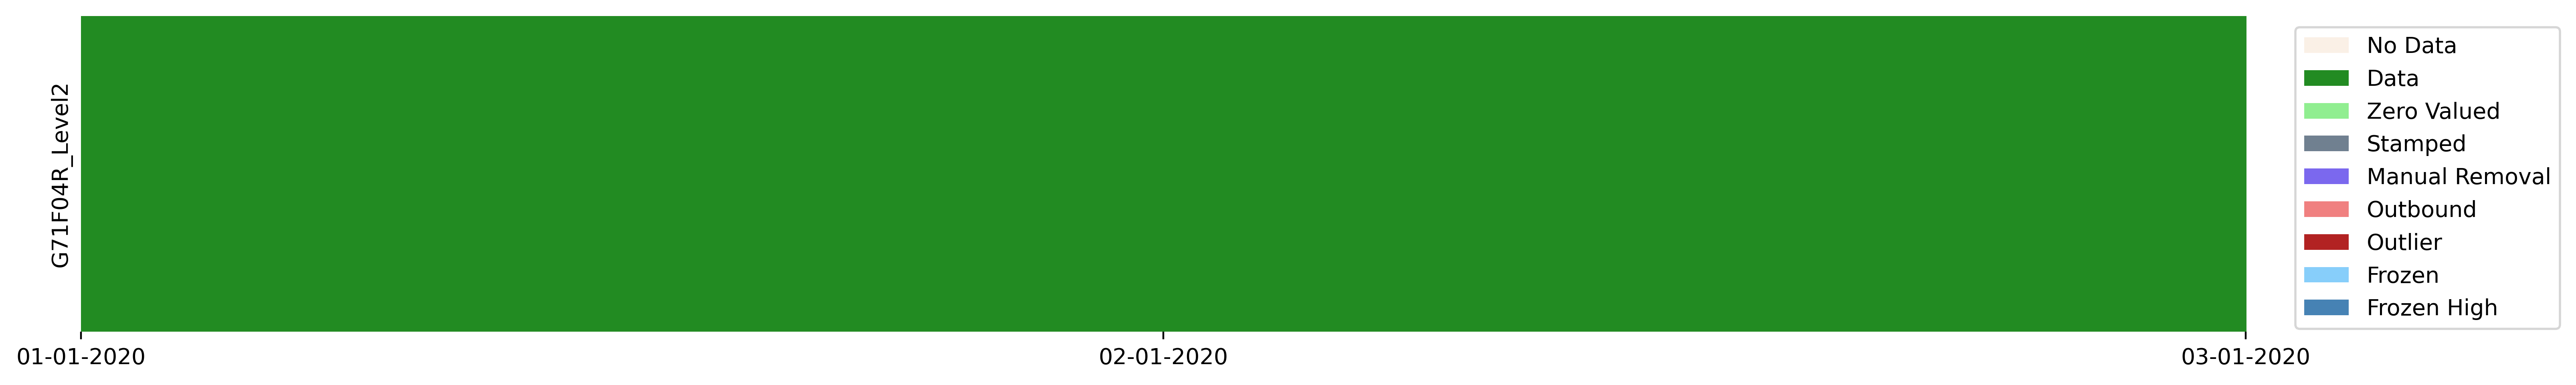

In [65]:
# visualize the timeline
visualize_single_timeline(period_I, period_timestamps_df, series_name, indicator_2_color, name_2_color, figsize=(16, 2.5))


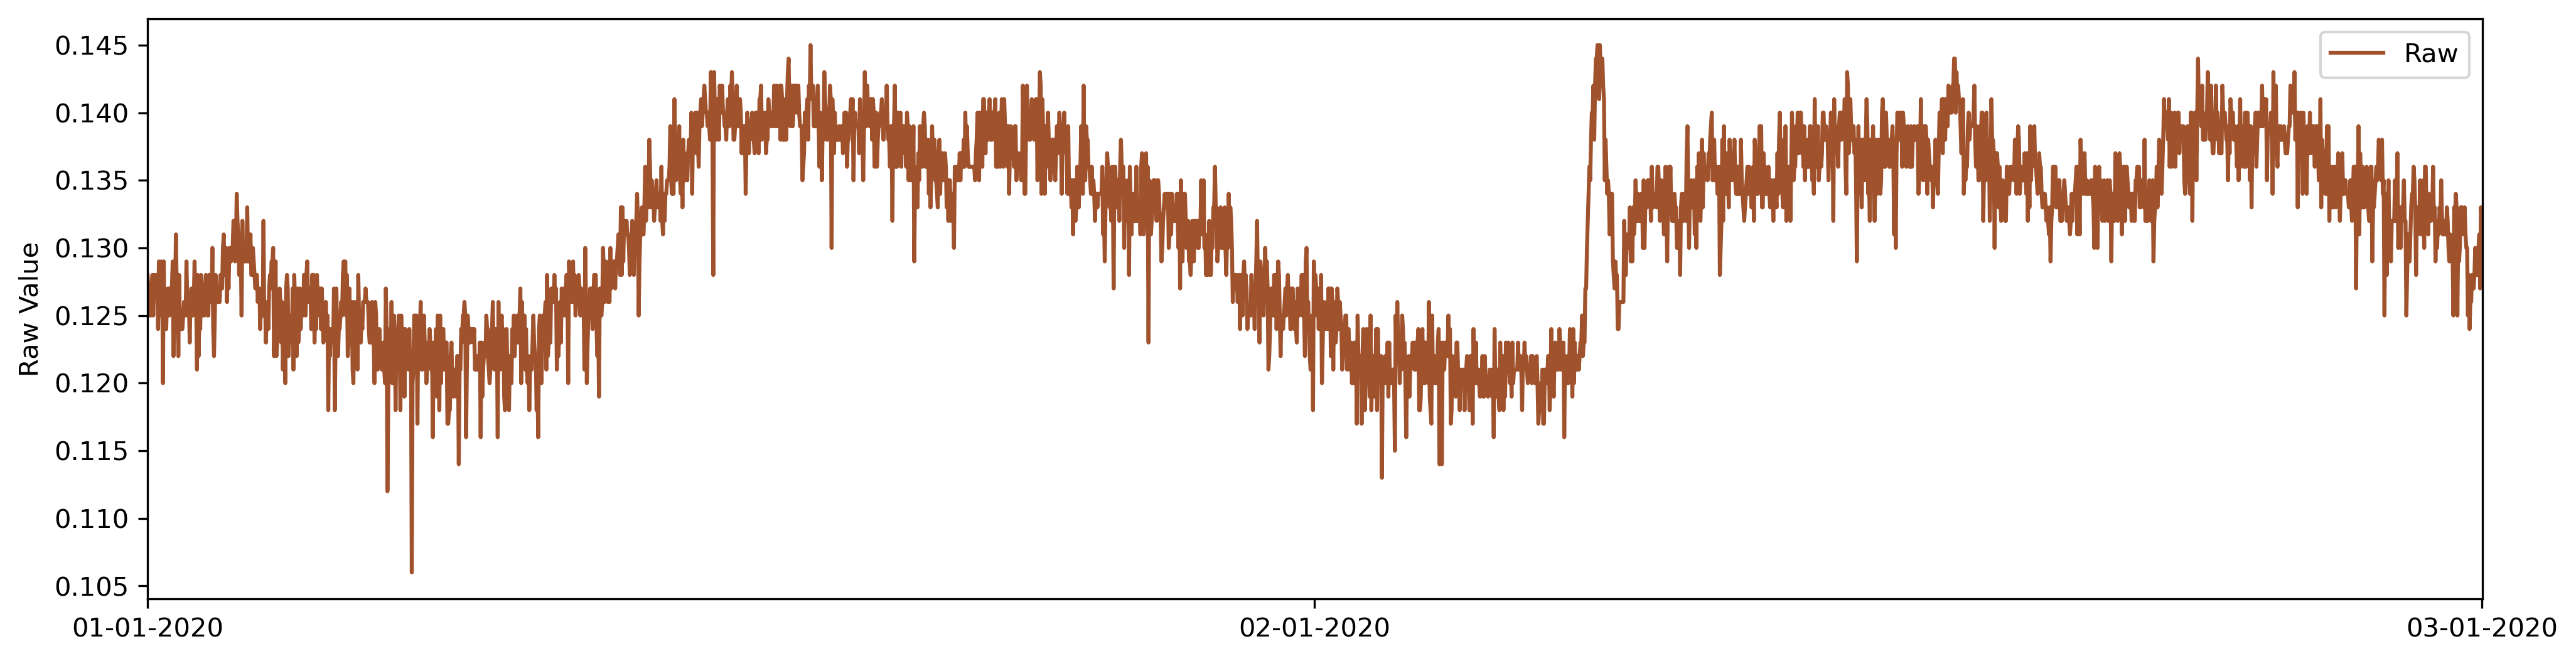

In [70]:
# visualize the raw value
fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
#ax.plot(period_series.index, period_series.raw, color='sienna', label='Raw')
ax.plot(range(len(period_series)), period_series.raw, color='chocolate', label='Raw')
ax.set_ylabel('Raw Value')
ax = set_meaningful_xaxis_timestamps(ax, period_timestamps_df)
ax.legend()
plt.show()



trends
- decomposition
    - trend: does something increase/decrease over time?
    - seasonality: regular patterns? day, week, month?
    - cyclical patterns for day

# Errors

In [29]:
def visualize_series_with_error(period_series, period_I, timestamps, indicator_2_color, name_2_color):
    # visualize the raw value
    fig, ax = plt.subplots(figsize=(16, 4), dpi=300)
    ax.plot(range(len(period_series)), period_series.raw, color='chocolate', label='Raw', linewidth=0.8)
    legend_elements = [Patch(facecolor='chocolate', label='Raw')]
    ax = set_meaningful_xaxis_timestamps(ax, timestamps)
    segment_starts, segment_ends, segment_color = get_segment_start_end_color(period_I, indicator_2_color)
    # visualize the segments with axvspan
    prev_colors = []
    for start, end, color in zip(segment_starts, segment_ends, segment_color):
        #if color not in ['forestgreen', 'lightgreen']:
        ax.axvspan(start, end, alpha=0.3, facecolor=color)
        if color not in prev_colors:
            legend_elements.append(Patch(facecolor=color, label=color_2_name[color]))
        prev_colors.append(color)

    #legend_elements = list(set(legend_elements))
    ax.legend(handles=legend_elements, loc='upper right', bbox_to_anchor=(1.15, 1))
    # remvoe the outer frame
    ax.spines['top'].set_visible(False); ax.spines['right'].set_visible(False); ax.spines['left'].set_visible(False); ax.spines['bottom'].set_visible(False)
    plt.tight_layout()
    plt.show()

In [30]:
# for each error present, get its first start time
error_start_times = {}
for error in error_indicators:
    only_error = series[series[error] > 0]
    # check if there is any error
    if only_error.shape[0] > 0:
        error_start_times[error] = only_error.index[0]
    else:
        print(f'No error for {error}')

error_start_times

No error for stamped
No error for outlier
No error for frozen_high


{'man_remove': Timestamp('2020-01-06 08:41:00'),
 'outbound': Timestamp('2010-08-23 12:55:00'),
 'frozen': Timestamp('2010-11-15 00:28:00')}

man_remove: 2020-01-06 08:41:00


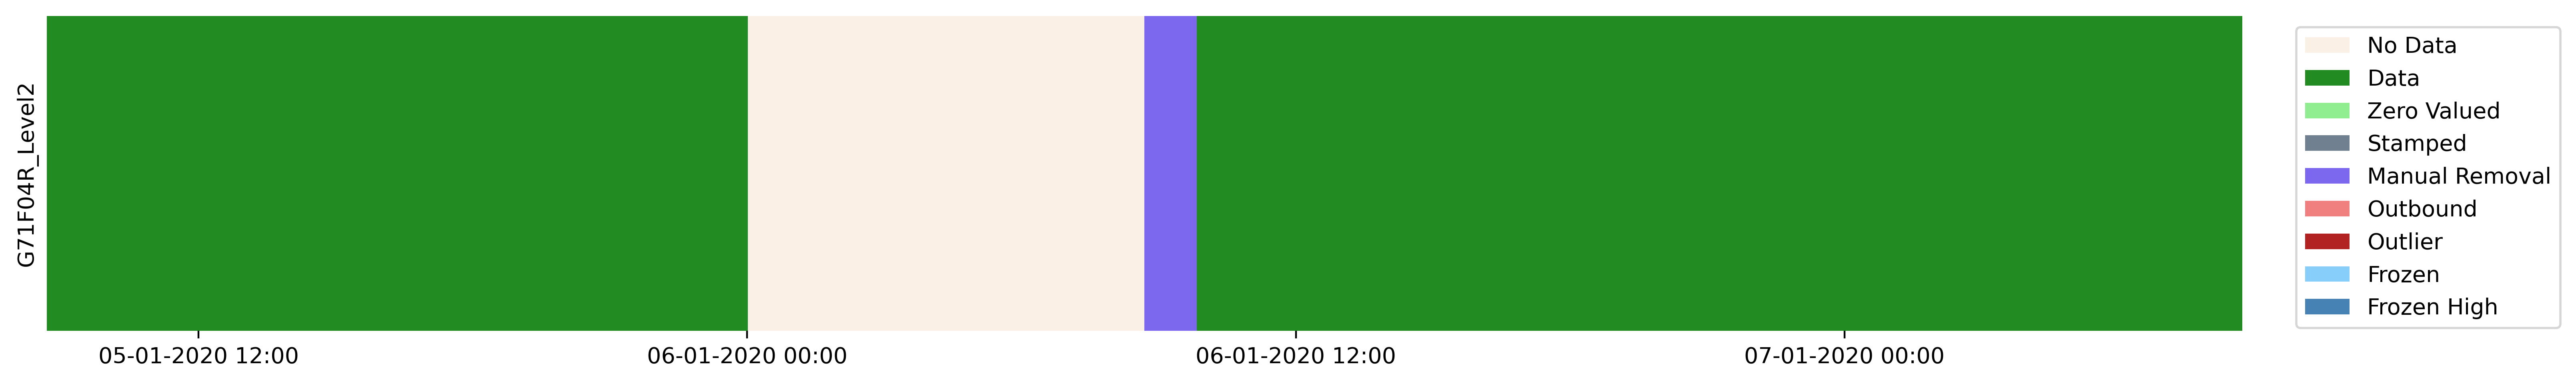

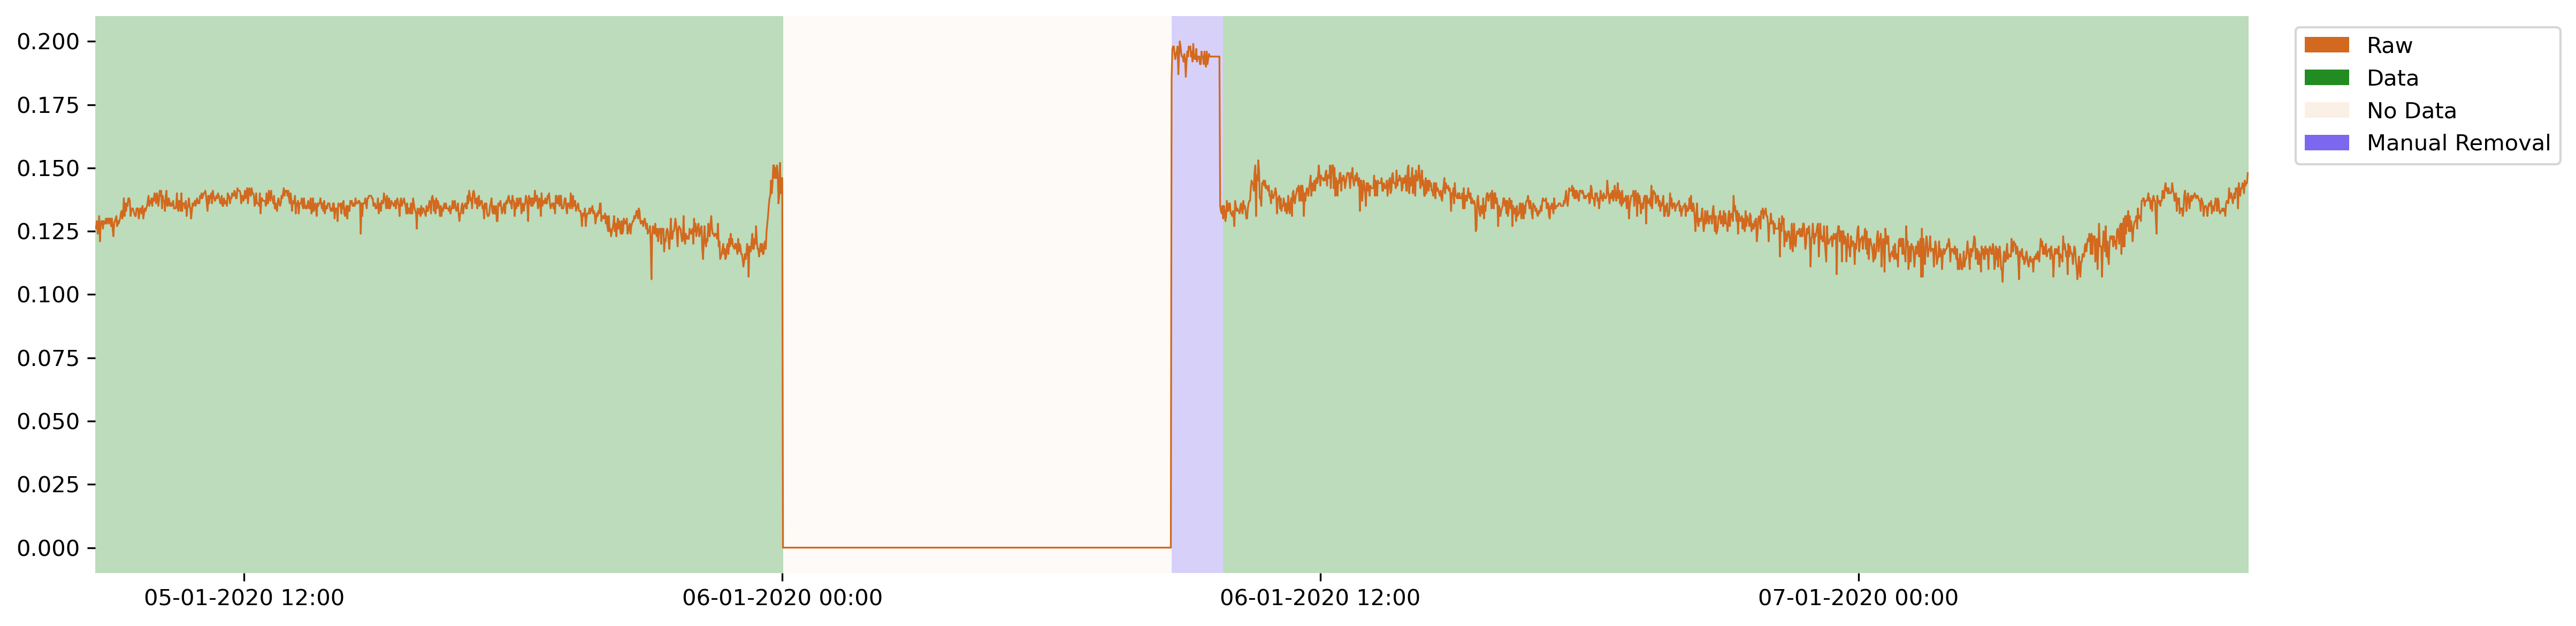

In [31]:
for error in error_start_times:
    print(f"{error}: {error_start_times[error]}")
    #error = 'man_remove'

    start_period = error_start_times[error] - pd.Timedelta(days=1)
    end_period = error_start_times[error] + pd.Timedelta(days=1)

    period_series = filter_df(series, timestamps, start_period, end_period)
    period_timestamps_df, period_I = create_series_I(period_series, error_indicators)
    # visualize the timeline
    visualize_single_timeline(period_I, period_timestamps_df, series_name, indicator_2_color, name_2_color, figsize=(16, 2.5))

    # visualize the raw value
    visualize_series_with_error(period_series, period_I, period_timestamps_df, indicator_2_color, name_2_color)

# Distribution

- Histogram, boxplot, qq

In [143]:
# # Assuming 'series' is a pandas Series containing the cleaned data
# cleaned_data = series['cleaned']

# # Create the histogram using Plotly Express for a concise approach
# fig = px.histogram(
#     cleaned_data,  
#     nbins=60,      
#     title='Histogram of Cleaned Data',  
#     template='plotly_white', 
#     color_discrete_sequence=['royalblue'],
#     opacity=0.8,
#     #log_y=True,
# )
# fig.update_traces(marker_line_color='white', marker_line_width=1)  
# fig.show()

In [144]:
# # Assuming 'series' is a pandas Series containing the cleaned data
# cleaned_data = series['cleaned']

# # Create the histogram using Plotly Express for a concise approach
# fig = px.histogram(
#     cleaned_data,  
#     nbins=60,      
#     title='Histogram of Cleaned Data',  
#     template='plotly_white', 
#     color_discrete_sequence=['royalblue'],
#     opacity=0.8,
#     log_y=True,
# )
# fig.update_traces(marker_line_color='white', marker_line_width=1)  
# fig.show()

In [145]:
# # Assuming 'series' is a pandas Series containing the cleaned data
# cleaned_data = series['cleaned']

# # Create the horizontal boxplot using px.box
# fig = px.box(
#     cleaned_data,  # Data to visualize
#     orientation='h',  # Set orientation to 'h' for horizontal boxplot
#     title='Distribution of Cleaned Data (Horizontal Boxplot)',  # Add a title
#     template='plotly_white'  # Optional: Use a white background template
# )

# # Display the horizontal boxplot
# fig.show()

# Correlation

- auto correlation

In [33]:
from scipy import signal

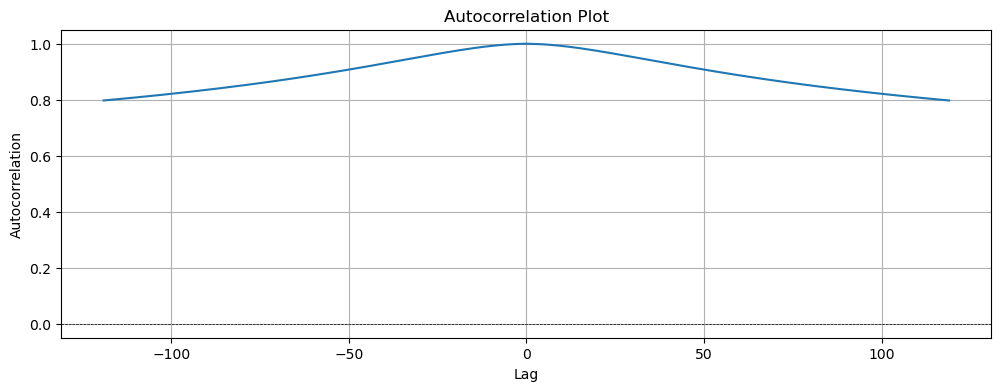

In [38]:
# Assuming 'series' is your pandas Series containing the data
cleaned_data = series['cleaned']

# remove all zeros
cleaned_data = cleaned_data[cleaned_data != 0]


# Function to calculate and plot autocorrelation
def plot_autocorrelation(data, num_lags):
    # Calculate autocorrelation using scipy's correlate function
    autocorr = signal.correlate(data, data, mode='full')
    autocorr /= np.correlate(data, data, mode='valid')[0]

    # Generate lag values
    lags = np.arange(-len(data) + 1, len(data))

    # Limit lags to the specified number
    lag_start = len(data) - num_lags
    lag_end = len(data) + num_lags - 1

    # Create the autocorrelation plot
    plt.figure(figsize=(12, 4))
    plt.plot(lags[lag_start:lag_end], autocorr[lag_start:lag_end])
    plt.title('Autocorrelation Plot')
    plt.xlabel('Lag')
    plt.ylabel('Autocorrelation')
    plt.grid(True)
    plt.axhline(0, color='black', linewidth=0.5, linestyle='--')  # Optional: Add a horizontal line at y=0
    plt.show()

# Specify the number of lags you want to display
number_of_lags = 120  # You can change this to any number you like
plot_autocorrelation(cleaned_data, number_of_lags)